<a href="https://colab.research.google.com/github/Umang-Lodaya/Technocrats_LOC-5.0/blob/main/doc_image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os.path
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from glob import glob

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
base = "/content/drive/MyDrive/LOC Technocrats/Id-Dataset"
dir = ["NewAadhar", "pan_data_imgs"]

In [5]:
os.path.join(base,dir[0])

'/content/drive/MyDrive/LOC Technocrats/Id-Dataset/NewAadhar'

In [6]:
a_paths = glob(os.path.join(base,dir[0],'*.png'))
p_paths = glob(os.path.join(base,dir[1],'*.jpg'))

In [7]:
df1 = pd.DataFrame(a_paths, columns=['Filepath'])
df1['Label'] = 'AADHAAR'

df2 = pd.DataFrame(p_paths, columns=['Filepath'])
df2['Label'] = 'PAN'

In [8]:
df1.shape

(1000, 2)

In [9]:
df2.head()

,Filepath,Label
0,/content/drive/MyDrive/LOC Technocrats/Id-Data...,PAN
1,/content/drive/MyDrive/LOC Technocrats/Id-Data...,PAN
2,/content/drive/MyDrive/LOC Technocrats/Id-Data...,PAN
3,/content/drive/MyDrive/LOC Technocrats/Id-Data...,PAN
4,/content/drive/MyDrive/LOC Technocrats/Id-Data...,PAN


In [10]:
df = pd.concat([df1, df2])

In [11]:
df = df.sample(frac = 1)
df = df.reset_index()
df

,index,Filepath,Label
0,447,/content/drive/MyDrive/LOC Technocrats/Id-Data...,PAN
1,834,/content/drive/MyDrive/LOC Technocrats/Id-Data...,AADHAAR
2,511,/content/drive/MyDrive/LOC Technocrats/Id-Data...,PAN
3,349,/content/drive/MyDrive/LOC Technocrats/Id-Data...,AADHAAR
4,492,/content/drive/MyDrive/LOC Technocrats/Id-Data...,AADHAAR
...,...,...,...
1993,513,/content/drive/MyDrive/LOC Technocrats/Id-Data...,AADHAAR
1994,622,/content/drive/MyDrive/LOC Technocrats/Id-Data...,PAN
1995,14,/content/drive/MyDrive/LOC Technocrats/Id-Data...,PAN
1996,174,/content/drive/MyDrive/LOC Technocrats/Id-Data...,PAN


In [12]:
length = df.shape[0]

In [13]:
train_df = df.iloc[:int(0.8*length), :]
test_df = df.iloc[int(0.8*length):, :]

# Creating Train_df

In [15]:
list(train_img_dir.glob(r'**/*.jpeg'))

NameError: ignored

In [ ]:
filepath = list(train_img_dir.glob(r'**/*.jpeg'))
Label = list(map(lambda x : os.path.split(os.path.split(x)[0])[1], filepath))
filepath = pd.Series(filepath, name = "Filepath").astype(str)
Label = pd.Series(Label, name = 'Label')
train_df = pd.concat([filepath, Label], axis = 1).sample(frac = 1.0, random_state = 1).reset_index(drop = True)

# Creating Test_df

In [ ]:
filepath = list(test_img_dir.glob(r'**/*.jpeg'))
Label = list(map(lambda x : os.path.split(os.path.split(x)[0])[1], filepath))
filepath = pd.Series(filepath, name = "Filepath").astype(str)
Label = pd.Series(Label, name = 'Label')
test_df = pd.concat([filepath, Label], axis = 1).sample(frac = 1.0, random_state = 1).reset_index(drop = True)

In [ ]:
train_df.shape

In [ ]:
test_df.shape

# Image Generator

In [16]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          #  rotation_range = 30,
                                                          #  zoom_range = 0.2,
                                                          #  width_shift_range=0.1,
                                                          #  height_shift_range = 0.1,
                                                          #  horizontal_flip = False,
                                                          #  vertical_flip = False,
                                                           validation_split = 0.2)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [17]:
train_img = train_gen.flow_from_dataframe(dataframe = train_df,
                                         x_col = 'Filepath',
                                         y_col = 'Label',
                                         target_size = (224,224),
                                         color_mode = 'rgb',
                                         class_mode = 'binary',
                                         batch_size = 32,
                                         shuffle = True,
                                         seed = 42,
                                         subset = 'training')

val_img = train_gen.flow_from_dataframe(dataframe = train_df,
                                         x_col = 'Filepath',
                                         y_col = 'Label',
                                         target_size = (224,224),
                                         color_mode = 'rgb',
                                         class_mode = 'binary',
                                         batch_size = 32,
                                         shuffle = True,
                                         seed = 42,
                                         subset = 'validation')

test_img = test_gen.flow_from_dataframe(dataframe = test_df,
                                         x_col = 'Filepath',
                                         y_col = 'Label',
                                         target_size = (224,224),
                                         color_mode = 'rgb',
                                         class_mode = 'binary',
                                         batch_size = 32,
                                         shuffle = False)

Found 1279 validated image filenames belonging to 2 classes.
Found 319 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.


# Model Training

In [18]:
inputs = tf.keras.Input(shape = (224,224,3))
x = tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3),activation = 'relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAvgPool2D()(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs)
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])
history = model.fit(train_img, validation_data = val_img,
                   epochs = 10,
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                               patience = 5,
                                                               restore_best_weights = True))


Epoch 1/10
40/40 [==============================] - 452s 11s/step - loss: 0.5853 - accuracy: 0.7451 - val_loss: 0.3325 - val_accuracy: 1.0000
Epoch 2/10
40/40 [==============================] - 11s 274ms/step - loss: 0.0822 - accuracy: 1.0000 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 3/10
40/40 [==============================] - 12s 312ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 8.1484e-04 - val_accuracy: 1.0000
Epoch 4/10
40/40 [==============================] - 11s 286ms/step - loss: 6.0201e-04 - accuracy: 1.0000 - val_loss: 3.8820e-04 - val_accuracy: 1.0000
Epoch 5/10
40/40 [==============================] - 11s 285ms/step - loss: 2.8592e-04 - accuracy: 1.0000 - val_loss: 1.8874e-04 - val_accuracy: 1.0000
Epoch 6/10
40/40 [==============================] - 13s 326ms/step - loss: 1.5612e-04 - accuracy: 1.0000 - val_loss: 1.1680e-04 - val_accuracy: 1.0000
Epoch 7/10
40/40 [==============================] - 11s 269ms/step - loss: 1.0174e-04 - accuracy: 1.0000 - val_loss

# Results

In [20]:
results = model.evaluate(test_img, verbose = 0)
print(f'Test Loss : {round(results[0], 3)}')
print(f'Test Accuracy : {round(results[1], 4)*100}%')

Test Loss : 0.0
Test Accuracy : 100.0%


# Training & Validation Image (Accuracy vs Loss )

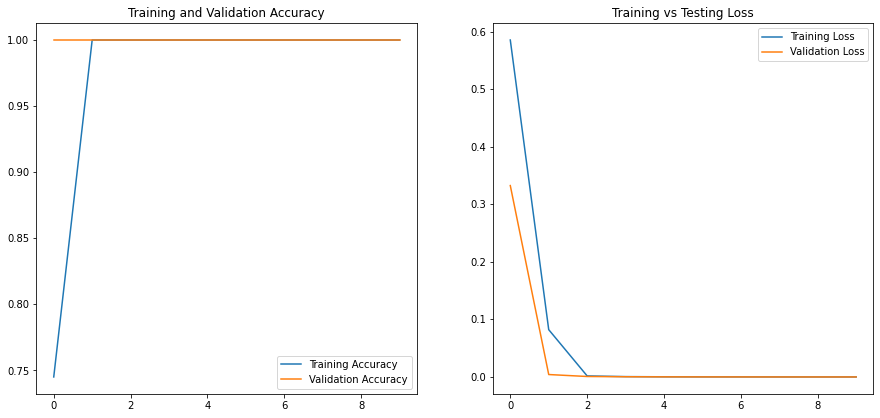

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)
plt.figure(figsize=(15, 15))
plt.subplot(2,2,1)
plt.plot(epochs_range, acc,label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2,2,2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training vs Testing Loss')
plt.show()

# Confusion Matrix & Classification Report

13/13 [==============================] - 3s 227ms/step


<ipython-input-24-a385e5678e0f>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_img_pred = (model.predict(test_img) >= 0.5).astype(np.int)


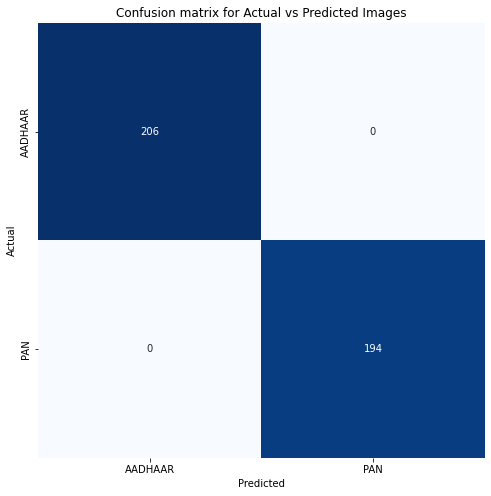

Classification Report---------->
               precision    recall  f1-score   support

     AADHAAR       1.00      1.00      1.00       206
         PAN       1.00      1.00      1.00       194

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



In [24]:
test_img_pred = (model.predict(test_img) >= 0.5).astype(np.int)
cm = confusion_matrix(test_img.labels, test_img_pred, labels =[0,1])
clr = classification_report(test_img.labels, test_img_pred, labels = [0,1], target_names= ['AADHAAR','PAN'])
plt.figure(figsize = (8,8))
sns.heatmap(cm, annot = True, fmt = 'g', cbar = False, cmap = 'Blues')
plt.title('Confusion matrix for Actual vs Predicted Images')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks = [0.5, 1.5], labels= ['AADHAAR','PAN'])
plt.yticks(ticks= [0.5, 1.5], labels= ['AADHAAR','PAN'])
plt.show()
print('Classification Report---------->\n',clr)
                            
                            

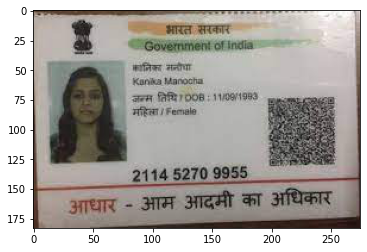

In [44]:
a1 = plt.imread('/content/drive/MyDrive/LOC Technocrats/Id-Dataset/aadhar/1.jpg')
a2 = plt.imread('/content/drive/MyDrive/LOC Technocrats/Id-Dataset/pan/100.jpg')
plt.imshow(a1)

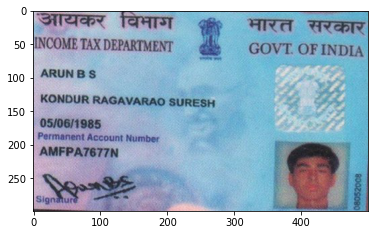

In [45]:
plt.imshow(a2)

In [33]:
a1.shape

(183, 275, 3)

In [35]:
import cv2

In [46]:
a1 = cv2.resize(a1, (224, 224))
a2 = cv2.resize(a2, (224, 224))

In [48]:
model.predict(np.array([a1, a2]))

1/1 [==============================] - 0s 136ms/step


array([[0.],
       [1.]], dtype=float32)